# **Regression Project (Store Sales -- Time Series Forecasting)**

# Introduction

Welcome to a compelling journey into the realm of time series forecasting! In this project, we embark on the intriguing challenge of predicting store sales using data from Corporation Favorita, a prominent grocery retailer based in Ecuador. As we delve into the intricacies of this task, our primary objective is to construct a robust model capable of accurately predicting the unit sales for a myriad of items across various Favorita stores.

The foundation of our predictive prowess lies in a diverse array of data points, including dates, store and product details, information about promotional activities, and, crucially, the corresponding sales figures. Our dataset is enriched with supplementary files containing additional information, providing a wealth of insights that can be harnessed to enhance the predictive capabilities of our models.

Join us as we navigate through the nuances of this time series forecasting problem, unraveling patterns, and leveraging comprehensive data to build a model that not only forecasts sales accurately but also unveils the underlying dynamics of retail operations within Corporation Favorita. Your journey begins here, where data science meets the world of retail, promising a captivating exploration of analytics and forecasting.

# **Project Description**

## Objective

This project aims to develop a robust time series forecasting model to predict store sales for Corporation Favorita, a leading grocery retailer in Ecuador. By leveraging advanced analytics, the goal is to provide accurate predictions for unit sales across a diverse range of items in different Favorita stores. The insights derived from this forecasting model will empower Favorita with data-driven decision-making capabilities, optimizing inventory management, promotional strategies, and overall business performance.

## Scope

The project encompasses the exploration and analysis of a comprehensive dataset, including dates, store details, product information, promotional activities, and sales figures. Supplementary files containing additional information will be utilized to enhance the predictive capabilities of the models.

## **Data Field Information:** 

**1. train.csv:**
Description: The training data, comprising a time series of features including store_nbr, family, onpromotion, and the target variable sales.
Data Fields:
store_nbr: Identifies the store where products are sold.
family: Identifies the type of product sold.
sales: Total sales for a product family at a specific store on a given date.
onpromotion: Total number of items in a product family that were being promoted at a store on a given date.

**2. test.csv:**
Description: The test data, having the same features as the training data. Used to predict target sales for the 15 days after the last date in the training data.
Data Fields:
Same as the train.csv data fields.

**3. transaction.csv:**
Description: Contains information about transactions made on specific dates.
Data Fields:
date: Date of the transaction.
store_nbr: Identifies the store where the transaction occurred.
Additional details about the transaction.
**4. sample_submission.csv:**
Description: A sample submission file in the correct format.

**5. stores.csv:**
Description: Store metadata, including city, state, type, and cluster. Cluster represents a grouping of similar stores.
Data Fields:
store_nbr: Identifies the store.
city: City where the store is located.
state: State where the store is located.
type: Type of the store.
cluster: Grouping of similar stores.

**6. oil.csv:**
Description: Daily oil prices, including values during both the train and test data timeframes. Given Ecuador's dependency on oil, its economical health is highly vulnerable to shocks in oil prices.

**7. holidays_events.csv:**
Description: Holidays and Events metadata, including information about transferred holidays.
Data Fields:
date: Date of the holiday or event.
Additional metadata about the holiday or event.

## **The Hypothesis**

### **Null Hypothesis (H0):** There is no significant difference in sales between promoted and non-promoted items.

### **Alternative Hypothesis (H1):** Items that are promoted have significantly higher sales compared to non-promoted items.

## **The Analytical Questions**

1.  Do items on promotion sell more, and is this difference statistically significant?
2.  Are sales different between different types of stores?
3.  Does the daily oil price correlate with overall sales?
4.  Do sales change significantly during holidays?
5.  Do some products consistently sell more during certain seasons?
6.  Do sales patterns vary depending on the day of the week?

In [60]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px

# Statistical Analysis
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


# Feature Processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import RandomizedSearchCV
import pickle


# Other Packages
import warnings
warnings.filterwarnings("ignore")

In [61]:
# Load environment variables from .env file into a dictionary
environment_variables=dotenv_values('.env')

# Loading the dataset 

Loading data from the servers

In [62]:
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("servername")
database = environment_variables.get("databasename")
username = environment_variables.get("user")
password = environment_variables.get("password")
table = environment_variables.get("tablename")

#connection_string = f"DRIVER={{SQL Server}}; servername={server};databasename={database};user={username};password={passwo
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [63]:
# Establish a connection to the database using the provided connection string.
connection=pyodbc.connect(connection_string)

In [64]:
# SQL query to fetch data from 'dbo.oil' table
query = "Select * from dbo.oil"

 
# Read data from the SQL query result
df_oil = pd.read_sql(query, connection)
 
 # Display the first few rows of the DataFrame
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [65]:
# SQL query to fetch data from 'dbo.holidays_events' table
query = "Select * from dbo.holidays_events"

# Read data from the SQL query result
df_holidays_events = pd.read_sql(query, connection)
 # Display the first few rows of the DataFrame
df_holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [66]:

# SQL query to fetch data from 'dbo_stores' table
query = "Select * from dbo.stores"

 
# Read data from the SQL query result
df_stores = pd.read_sql(query, connection)
 
 # Display the first few rows of the DataFrame
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


Loading the data from onedrive

In [67]:
sample_submission=pd.read_csv('sample_submission.csv')
sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


In [68]:
test=pd.read_csv('test.csv', index_col=0,parse_dates=True)
test.head()

,date,store_nbr,family,onpromotion
id,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0
3000889,2017-08-16,1,BABY CARE,0
3000890,2017-08-16,1,BEAUTY,2
3000891,2017-08-16,1,BEVERAGES,20
3000892,2017-08-16,1,BOOKS,0


Loading data from github resipitory 

In [85]:
transactions=pd.read_csv('transactions.csv')
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [84]:
train=pd.read_csv('train.csv',index_col=0,parse_dates=True)
train.head()

,date,store_nbr,family,sales,onpromotion
id,,,,,
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0


## 3. Exploratory Data Analysis (EDA)

Exploring the oil dataset

In [71]:
# Get the column information of each dataset
# Function to display column information of the datasets
def show_column_info(dataset_name, dataset):
    print(f"Data types for the {dataset_name} dataset:")
    print(dataset.info())
    print('==='*14)

In [72]:
# Column information of the train and test columns
show_column_info('Train', train)
print()
show_column_info('Test', test)

Data types for the Train dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   date         object 
 1   store_nbr    int64  
 2   family       object 
 3   sales        float64
 4   onpromotion  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 137.4+ MB
None

Data types for the Test dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 28512 entries, 3000888 to 3029399
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         28512 non-null  object
 1   store_nbr    28512 non-null  int64 
 2   family       28512 non-null  object
 3   onpromotion  28512 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB
None


Train Dataset:

Number of Entries: 3,000,888

Columns:

1. id: Unique identifier for each entry, stored as an integer (int64).
2. date: Date of the recorded data, stored as an object. Considering converting to datetime type for date-related operations.
3. store_nbr: Store number, stored as an integer (int64).
4. family: Product family category, stored as an object (likely a string).
5. sales: Sales data, recorded as a float (float64).
6. onpromotion: Binary indicator (0 or 1) for whether the product is on promotion, stored as an integer (int64).



Test Dataset:

Number of Entries: 28,512

Columns:

1. id: Unique identifier for each entry, stored as an integer (int64).
2. date: Date of the recorded data, stored as an object. Consider converting to datetime type for date-related operations.
3. store_nbr: Store number, stored as an integer (int64).
4. family: Product family category, stored as an object (likely a string).
5. onpromotion: Binary indicator (0 or 1) for whether the product is on promotion, stored as an integer (int64).



NOTE:- These datasets seem suitable for tasks related to sales forecasting or analysis, with information about sales, store numbers, product families, and promotion status. If time-series analysis is involved, considering converting the 'date' column to datetime type.

In [73]:
# Column information of the other datasets
show_column_info('Holiday events', df_holidays_events)
print()
show_column_info('Oil', df_oil)
print()
show_column_info('Stores', df_stores)
print()
show_column_info('Transactions', transactions)

Data types for the Holiday events dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None

Data types for the Oil dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None

Data types for the Stores dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Dat

**Holiday Events Dataset:**

Number of Entries: 350

Columns:

1. date: Date of the holiday event, stored as an object (likely a string).
2. type: Type of holiday, stored as an object.
3. locale: Locale information, stored as an object.
4. locale_name: Name of the locale, stored as an object.
5. description: Description of the holiday event, stored as an object.
6. transferred: Boolean indicator (True/False) representing whether the holiday was transferred, stored as a boolean.

**Oil Dataset:**

Number of Entries: 1218

Columns:

1. date: Date of the oil data, stored as an object (likely a string).
2. dcoilwtico: WTI (West Texas Intermediate) crude oil price, stored as a float.

**Stores Dataset:**

Number of Entries: 54

Columns:

1. store_nbr: Store number, stored as an integer (int64).
2. city: City where the store is located, stored as an object.
3. state: State where the store is located, stored as an object.
4. type: Type of store, stored as an object.
5. cluster: Cluster identifier, stored as an integer (int64).


**Transactions Dataset:**

Number of Entries: 83,488

Columns:

1. date: Date of the transaction, stored as an object (likely a string).
2. store_nbr: Store number, stored as an integer (int64).
3. transactions: Number of transactions, stored as an integer (int64).


These datasets contain information related to holidays, oil prices, stores, and transactions, each with its own set of columns and data types. When working with date-related information, considering converting the 'date' columns to datetime type for time-series analysis or other date-based operations.

### Transforming the 'date' column to datetime format

In [74]:
# Print column names
print("Train columns:", train.columns)
print("Test columns:", test.columns)
print("Holidays Events columns:", df_holidays_events.columns)
print("Oil columns:", df_oil.columns)
print("Transactions columns:", transactions.columns)

Train columns: Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')
Test columns: Index(['date', 'store_nbr', 'family', 'onpromotion'], dtype='object')
Holidays Events columns: Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')
Oil columns: Index(['date', 'dcoilwtico'], dtype='object')
Transactions columns: Index(['date', 'store_nbr', 'transactions'], dtype='object')


In [75]:
# Transactions dataset
transactions.set_index('date', inplace=True)

In [78]:
print("Transactions columns:", transactions.columns)

Transactions columns: Index(['store_nbr', 'transactions'], dtype='object')


In [83]:
# Print the first few rows
print("Train head:\n", train.head())
print("Test head:\n", test.head())
print("Holidays Events head:\n", df_holidays_events.head())
print("Oil head:\n", df_oil.head())
print("Transactions head:\n", transactions.head())

Train head:
          date  store_nbr      family  sales  onpromotion
id                                                      
0  2013-01-01          1  AUTOMOTIVE    0.0            0
1  2013-01-01          1   BABY CARE    0.0            0
2  2013-01-01          1      BEAUTY    0.0            0
3  2013-01-01          1   BEVERAGES    0.0            0
4  2013-01-01          1       BOOKS    0.0            0
Test head:
               date  store_nbr      family  onpromotion
id                                                    
3000888 2017-08-16          1  AUTOMOTIVE            0
3000889 2017-08-16          1   BABY CARE            0
3000890 2017-08-16          1      BEAUTY            2
3000891 2017-08-16          1   BEVERAGES           20
3000892 2017-08-16          1       BOOKS            0
Holidays Events head:
         date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01

In [86]:
# Converting the 'date' column in the datasets to datetime format
# Train dataset
train['date'] = pd.to_datetime(train['date'])

# Test dataset
test['date'] = pd.to_datetime(test['date'])

# Holiday Events dataset
df_holidays_events['date'] = pd.to_datetime(df_holidays_events['date'])

# Oil dataset
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Transactions dataset
transactions['date'] = pd.to_datetime(transactions['date'])

In [88]:
# Confirm the data type of the 'date' column after transformation
print('Date Column Data Type After Transformation:') 
print('==='*14)
print("Train dataset:", train['date'].dtype)
print("Test dataset:", test['date'].dtype)
print("Holiday Events dataset:", df_holidays_events['date'].dtype)
print("Oil dataset:", df_oil['date'].dtype)
print("Transactions dataset:", transactions['date'].dtype)

Date Column Data Type After Transformation:
Train dataset: datetime64[ns]
Test dataset: datetime64[ns]
Holiday Events dataset: datetime64[ns]
Oil dataset: datetime64[ns]
Transactions dataset: datetime64[ns]


In [89]:
# Checking for the summary statistics of the datasets 
datasets = {'train': train, 'test': test, 'holiday events': df_holidays_events, 'oil': df_oil, 'stores':df_stores, 'transactions': transactions}
for name, data in datasets.items():
    print(f"{name.capitalize()} dataset summary statistics:")
    print('---'*15)
    print(data.describe())
    print('==='*20)
    print()

Train dataset summary statistics:
---------------------------------------------
                                date     store_nbr         sales   onpromotion
count                        3000888  3.000888e+06  3.000888e+06  3.000888e+06
mean   2015-04-24 08:27:04.703088384  2.750000e+01  3.577757e+02  2.602770e+00
min              2013-01-01 00:00:00  1.000000e+00  0.000000e+00  0.000000e+00
25%              2014-02-26 18:00:00  1.400000e+01  0.000000e+00  0.000000e+00
50%              2015-04-24 12:00:00  2.750000e+01  1.100000e+01  0.000000e+00
75%              2016-06-19 06:00:00  4.100000e+01  1.958473e+02  0.000000e+00
max              2017-08-15 00:00:00  5.400000e+01  1.247170e+05  7.410000e+02
std                              NaN  1.558579e+01  1.101998e+03  1.221888e+01

Test dataset summary statistics:
---------------------------------------------
                      date     store_nbr   onpromotion
count                28512  28512.000000  28512.000000
mean   2017-08-23 1

In [91]:
# Check for missing values in the datasets
datasets = {'train': train, 'test': test, 'holiday events': df_holidays_events, 'oil': df_oil, 'stores': df_stores, 'transactions': transactions, }

def show_missing_values(datasets):
    for name, data in datasets.items():
        print(f"Missing values in the {name.capitalize()} dataset:")
        print(data.isnull().sum())
        print('===' * 18)
        print()

show_missing_values(datasets)

Missing values in the Train dataset:
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Missing values in the Test dataset:
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64

Missing values in the Holiday events dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

Missing values in the Oil dataset:
date           0
dcoilwtico    43
dtype: int64

Missing values in the Stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

Missing values in the Transactions dataset:
date            0
store_nbr       0
transactions    0
dtype: int64



In [92]:
# Visualizing the 'dcoilwtico' column to Identify a Strategy for Handling Missing Values
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [93]:
# use missing values with backfill
df_oil = pd.DataFrame(df_oil)
df_oil = df_oil.bfill()

In [94]:
df_oil.isnull().sum()

date          0
dcoilwtico    0
dtype: int64

In [95]:
# Visualizing the 'dcoilwtico' after filling with backfill
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Checking for the completeness of the 'date' column in the Train Dataset

In [96]:
# Check the completeness of the train dataset
min_date = train['date'].min()
max_date = train['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(df_train['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

In [99]:
# Complete the missing dates in the train dataset
# Create an index of the missing dates as a DatetimeIndex object
missing_dates = pd.Index(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]')

# Create a DataFrame with the missing dates, using the 'date' column
missing_data = pd.DataFrame({'date': missing_dates})

# Concatenate the original train dataset and the missing data DataFrame
# ignore_index=True ensures a new index is assigned to the resulting DataFrame
train = pd.concat([train, missing_data], ignore_index=True)

# Sort the DataFrame based on the 'date' column in ascending order
train.sort_values('date', inplace=True)

In [102]:
# Check the completeness of the train dataset
min_date = train['date'].min()
max_date = train['date'].max()
expected_dates = pd.date_range(start=min_date, end=max_date)

missing_dates = expected_dates[~expected_dates.isin(train['date'])]

if len(missing_dates) == 0:
    print("The train dataset is complete. It includes all the required dates.")
else:
    print("The train dataset is incomplete. The following dates are missing:")
    print(missing_dates)

The train dataset is complete. It includes all the required dates.


### Merging The Train Dataset with the Stores, Transactions, Holiday Events and Oil Dataset

In [104]:
# Merging the common columns ('store_nbr' and 'date') in the datasets using the inner merge() function
# Merge train_df with stores_df based on 'store_nbr' column
merged_df1 = train.merge(df_stores, on='store_nbr', how='inner')

# Merge merged_df1 with transactions_df based on 'date' and 'store_nbr' columns
merged_df2 = merged_df1.merge(transactions, on=['date', 'store_nbr'], how='inner')

# Merge merged_df2 with holidays_events_df based on 'date' column
merged_df3 = merged_df2.merge(df_holidays_events, on='date', how='inner')

# Merge merged_df3 with oil_df based on 'date' column
merged_df = merged_df3.merge(df_oil, on='date', how='inner')

# View the first five rows of the merged dataset
merged_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,type_y,locale,locale_name,description,transferred,dcoilwtico
0,2013-01-01,25.0,LAWN AND GARDEN,2.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,2013-01-01,25.0,LADIESWEAR,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,2013-01-01,25.0,HOME CARE,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,2013-01-01,25.0,HOME APPLIANCES,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,2013-01-01,25.0,HOME AND KITCHEN II,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


The use of an inner merge in this time series forecasting project for corporation Favorita helps to ensure data consistency, avoid missing values, and focus on the relevant data for accurate predictions.

An inner merge type retains only the rows with matching values in the specified columns. In the context of time series forecasting, it allows us to merge datasets based on a common time index or timestamp. By performing an inner merge, we ensure that only the rows with corresponding timestamps in both datasets are included in the merged result. This is important for time series forecasting because you want to align the data from different sources based on their timestamps to build a consistent and accurate forecasting model.

With an inner merge, you eliminate any non-matching timestamps, which may not be useful for forecasting and could introduce inconsistencies in the data. By focusing on the intersection of the datasets, we can create a merged dataset that contains the necessary information for accurate time series forecasting.

In [105]:
# Check the column information of the merged dataset
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   store_nbr     322047 non-null  float64       
 2   family        322047 non-null  object        
 3   sales         322047 non-null  float64       
 4   onpromotion   322047 non-null  float64       
 5   city          322047 non-null  object        
 6   state         322047 non-null  object        
 7   type_x        322047 non-null  object        
 8   cluster       322047 non-null  int64         
 9   transactions  322047 non-null  int64         
 10  type_y        322047 non-null  object        
 11  locale        322047 non-null  object        
 12  locale_name   322047 non-null  object        
 13  description   322047 non-null  object        
 14  transferred   322047 non-null  bool          
 15  dcoilwtico    322

The merged dataset after merging the train dataset with additional datasets contains 322,047 rows and 16 columns. Two columns have been renamed as a result of the merging, type_x and type_y.

In [106]:
# Check the unique values of the two unknown columns
print("Unique values of 'type_x':")
print(merged_df['type_x'].unique())
print()
print("Unique values of 'type_y':")
print(merged_df['type_y'].unique())

Unique values of 'type_x':
['D' 'E' 'C' 'A' 'B']

Unique values of 'type_y':
['Holiday' 'Additional' 'Transfer' 'Event' 'Bridge']


In [107]:
# Renaming the columns with the approapriate names
merged_df = merged_df.rename(columns={"type_x": "store_type", "type_y": "holiday_type"})
merged_df.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico
0,2013-01-01,25.0,LAWN AND GARDEN,2.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
1,2013-01-01,25.0,LADIESWEAR,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
2,2013-01-01,25.0,HOME CARE,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
3,2013-01-01,25.0,HOME APPLIANCES,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999
4,2013-01-01,25.0,HOME AND KITCHEN II,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999


In [108]:
# Generate summary statistics and transpose the rows and columns of the resultant DataFrame.
# Transposing flips the DataFrame (the rows become columns and the columns become rows) for better readability
merged_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,322047,2015-08-04 23:49:57.971104,2013-01-01 00:00:00,2014-07-23 00:00:00,2015-11-02 00:00:00,2016-05-27 00:00:00,2017-08-15 00:00:00,NaN
store_nbr,322047.0,26.994672,1.0,13.0,27.0,40.0,54.0,15.595174
sales,322047.0,406.383452,0.0,1.0,19.0,241.260505,124717.0,1246.88124
onpromotion,322047.0,3.727136,0.0,0.0,0.0,1.0,716.0,15.512095
cluster,322047.0,8.531202,1.0,4.0,9.0,13.0,17.0,4.713809
transactions,322047.0,1734.11784,54.0,1030.0,1409.0,2148.0,8359.0,1050.335018
dcoilwtico,322047.0,63.636381,27.959999,44.880001,51.98,94.089996,107.949997,24.855753


In [109]:
# Check for missing values in the merged datasets
missing_values = merged_df.isnull().sum()
missing_values

date            0
store_nbr       0
family          0
sales           0
onpromotion     0
city            0
state           0
store_type      0
cluster         0
transactions    0
holiday_type    0
locale          0
locale_name     0
description     0
transferred     0
dcoilwtico      0
dtype: int64

In [110]:
# Check for duplicate values in the merged dataset
duplicate_rows_merged = merged_df.duplicated()
duplicate_rows_merged.sum()

0

In [112]:
# Check for duplicate values in the test dataset
duplicate_rows_test = test.duplicated()
duplicate_rows_test.sum()

0

In [ ]:
merged_df.to_csv('Data/Visualization_Data.csv', index=False)
merged_df.head()

In [116]:
# Create A Copy of The Merged Dataset
merged_df_copy = merged_df.copy()
merged_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322047 entries, 0 to 322046
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date          322047 non-null  datetime64[ns]
 1   store_nbr     322047 non-null  float64       
 2   family        322047 non-null  object        
 3   sales         322047 non-null  float64       
 4   onpromotion   322047 non-null  float64       
 5   city          322047 non-null  object        
 6   state         322047 non-null  object        
 7   store_type    322047 non-null  object        
 8   cluster       322047 non-null  int64         
 9   transactions  322047 non-null  int64         
 10  holiday_type  322047 non-null  object        
 11  locale        322047 non-null  object        
 12  locale_name   322047 non-null  object        
 13  description   322047 non-null  object        
 14  transferred   322047 non-null  bool          
 15  dcoilwtico    322

## Univariate, Multivariate and Bivariate Analysis

### **Univariate Analysis for 'sales' variable:**

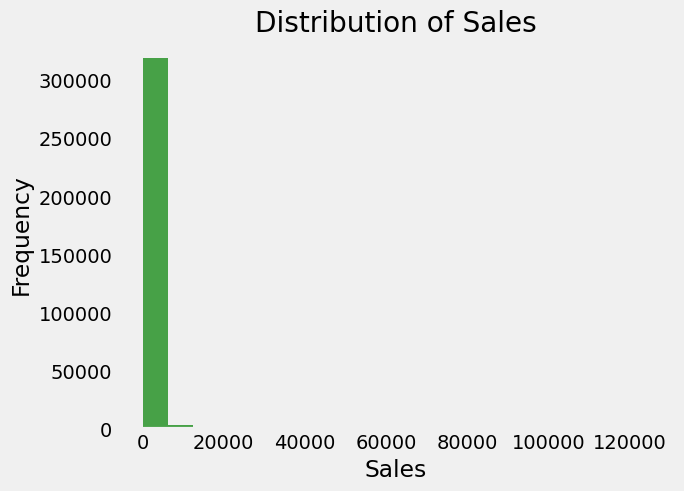

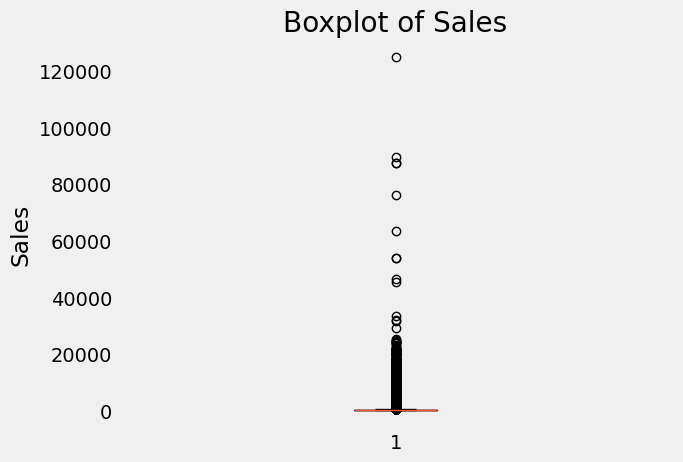

In [117]:
# Histogram
plt.hist(merged_df['sales'], bins=20, color='green', alpha=0.7 )
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')
plt.grid(False)
plt.show()

# Boxplot
plt.boxplot(merged_df['sales'] )
plt.ylabel('Sales')
plt.title('Boxplot of Sales')
plt.grid(False)
plt.show()

## Histogram:

Frequency Distribution: The histogram visually depicts the number of sales that fall within each range of sales values. This allows us to see which ranges have the highest and lowest concentrations of sales.
Peak: The prominent peak in the histogram highlights the range where the majority of sales occur. This indicates the most common sales value or a narrow range around it.
Right Skew: The histogram stretches towards the right, suggesting that while most sales fall within the central range, there are also some instances of significantly higher sales values. This creates a right-skewed distribution.

## Boxplot:

Outliers: The boxplot further confirms the presence of outliers in the data. These are data points that fall outside the whiskers (the lines extending from the box). Outliers can be valuable insights, potentially representing exceptional sales performance or unexpected events.
Quartiles: The box itself represents the quartiles: Q1 (25th percentile), the median (50th percentile), and Q3 (75th percentile). This provides information about the spread of the data and the values that separate the lower and upper halves.
Combined Insights:

By analyzing both the histogram and boxplot, we gain a comprehensive understanding of the sales distribution:

Majority of Sales: The majority of sales fall within the range represented by the peak in the histogram. This tells us about the typical sales performance and the expected revenue range.
Presence of High Values: The right skew and potential outliers in the boxplot indicate that while most sales are concentrated around the central range, there are also instances of significantly higher sales. This can be due to various factors like promotional campaigns, high-value customers, or exceptional product offerings.
Outlier Analysis: Analyzing the outliers can provide valuable insights into the reasons behind exceptionally high or low sales figures. This can help identify potential market trends, customer segments, or product variations that contribute to significant sales deviations.
Overall, the combined analysis of the histogram and boxplot paints a clear picture of the sales distribution, revealing the central tendencies, potential skewness, and presence of outliers. This information can be crucial for making informed business decisions, optimizing pricing strategies, and understanding customer behavior.

## **distribution of the 'transactions' variable:**

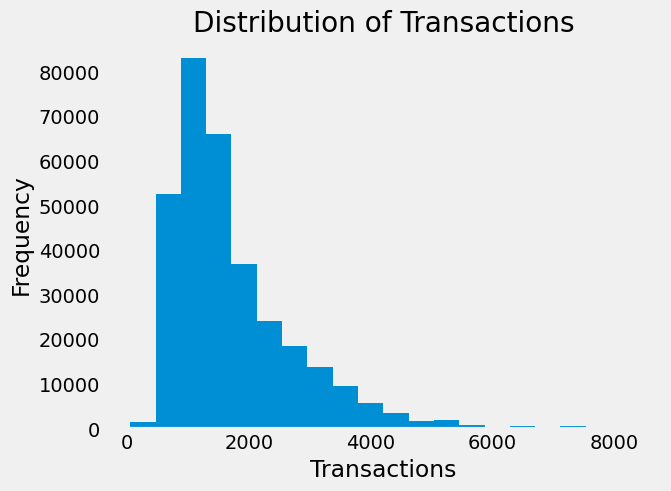

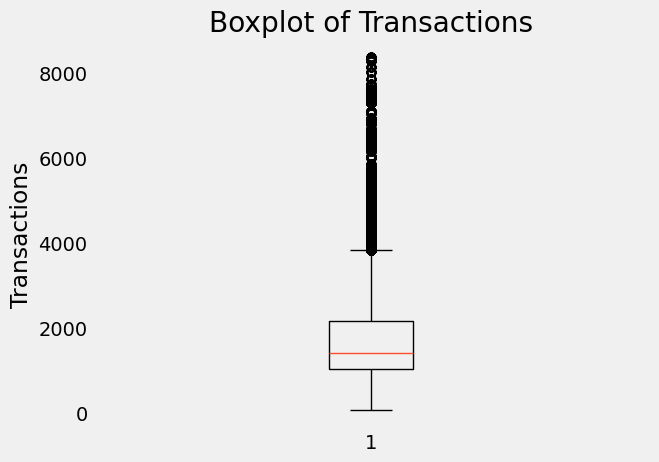

In [118]:
# Histogram
plt.hist(merged_df['transactions'], bins=20)
plt.xlabel('Transactions')
plt.ylabel('Frequency')
plt.title('Distribution of Transactions')
plt.grid(False)
plt.show()

# Boxplot
plt.boxplot(merged_df['transactions'])
plt.ylabel('Transactions')
plt.title('Boxplot of Transactions')
plt.grid(False)
plt.show()

## Key Insights from the Transaction Distribution Histogram:

Majority of Transactions Concentrated in a Specific Range:

The histogram's peak on the left side demonstrates that a significant proportion of transactions fall within a relatively narrow range.
This suggests that these transaction volumes are the most common or typical within the dataset.
Right-Skewed Distribution:

The histogram's shape extends towards the right, forming a right-skewed distribution.
This indicates that while most transactions cluster around a certain value, there are also instances of higher transaction volumes, albeit less frequent.
Right skewness often suggests a potential limitation or capping of the lower values, leading to a longer tail towards higher values.
Presence of a Cluster with Lower Frequency:

The histogram also reveals a distinct cluster of transactions with a lower frequency, separated from the main peak.
This hints at a potential pattern or subgroup within the data that warrants further investigation.
Implications:

**Understanding Typical Transaction Behavior:** The histogram's shape provides valuable insights into the typical transaction patterns within the dataset.
Identifying Outliers and Anomalies: The right skewness and the lower frequency cluster suggest the presence of certain deviations from the norm. These outliers could offer opportunities for further analysis and potentially reveal valuable insights.
Informing Business Decisions: Understanding the distribution of transactions can inform various business decisions, such as resource allocation, pricing strategies, and risk management.
Additional Considerations:

**Context and Data Origin:** The interpretation of the histogram should be guided by the specific context of the transactions and the origin of the data.
Correlation with Other Variables: Examining correlations between transaction volumes and other relevant variables can provide a more comprehensive understanding of the underlying patterns and relationships.

## **Distribution of the 'Daily Oil Price' variable:** ##

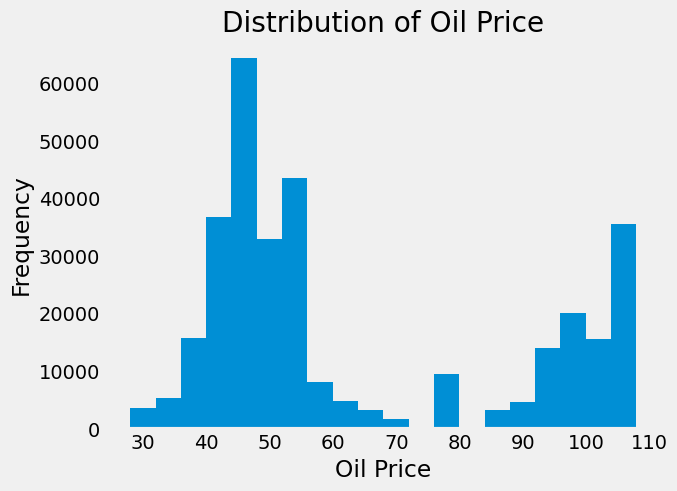

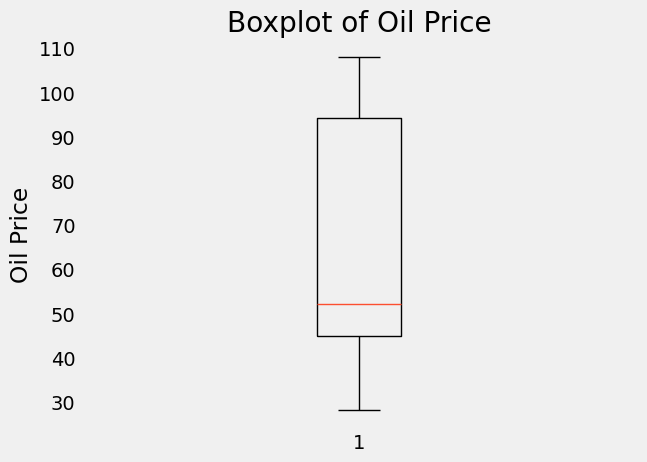

In [119]:
# Histogram
plt.hist(merged_df['dcoilwtico'], bins=20)
plt.xlabel('Oil Price')
plt.ylabel('Frequency')
plt.title('Distribution of Oil Price')
plt.grid(False)
plt.show()

# Boxplot
plt.boxplot(merged_df['dcoilwtico'])
plt.ylabel('Oil Price')
plt.title('Boxplot of Oil Price')
plt.grid(False)
plt.show()

## Unveiling the 'dcoilwtico' Distribution with Histograms and Boxplots:

By analyzing both the histogram and boxplot, we can gain valuable insights into the distribution of oil prices represented by the 'dcoilwtico' variable:

## Frequency Unveiled: The Histogram's Story

**Central Tendency:** The histogram visually depicts the number of times each oil price range occurs within the data. Its shape highlights the central tendency of the data, revealing which price ranges have the highest concentration of occurrences.
**Dominant Price Range:** Notice the prominent peak in the histogram? This indicates the price range where the highest number of oil prices fall. This range represents the most frequent or "typical" oil price encountered in the data.
Spreading the Spectrum: As we move away from the peak in either direction, the frequency of oil prices gradually decreases. This signifies a spread of prices around the central tendency, encompassing both lower and higher values.
Boxplot: Beyond the Frequencies

**Median Price:** The boxplot's central line, or the "box," represents the median price. This is the price that divides the data into two equal halves – 50% of the prices fall below it, and 50% fall above.
Quartiles Unmasked: The box's lower and upper edges, known as the first and third quartiles (Q1 and Q3), respectively, reveal the range within which the middle 50% of the data lies. The distance between these quartiles, visualized as the box's width, tells us about the spread of the central data.
**Whisker Wisdom:** The lines extending from the box, called whiskers, represent the range beyond which lie the remaining 25% of the data on either side. If the whiskers are long, it indicates the presence of outliers – data points significantly higher or lower than the bulk of the prices.
Combined Insights, Empowered Decisions:

## Analyzing both the histogram and boxplot together paints a richer picture of the 'dcoilwtico' distribution:

We understand the typical price range for oil, along with the spread of prices around it.
We identify the median price and the range encompassing the majority of data points.
We discover the presence of potential outliers, which may warrant further investigation.
This deeper understanding of oil price distribution can inform various decisions, such as:

Market Analysis: Identifying common price ranges and potential trends.
Risk Management: Assessing potential price fluctuations and outliers.
Trading Strategies: Making informed decisions based on price distribution patterns.
Remember, the specific interpretation of these insights will depend on the context and purpose of your analysis of the 'dcoilwtico' data. I hope this combined visual and textual explanation brings clarity and value to your exploration!

## Bivariate Analysis

## **Trend of sales over time.**

In [120]:
# Group the data by date and calculate the total sales
daily_sales = merged_df.groupby('date')['sales'].sum().reset_index()

# Create a time series plot with slider
fig = px.line(daily_sales, x='date', y='sales')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(title='Trend of Sales Over Time', title_x=0.5)
fig.show()

## Unveiling the Sales Story: A Journey Through Time

This plot reveals the fascinating journey of sales over time, offering valuable insights into the dynamics of your business. By peering into the graph, we can observe:

1. Fluctuations and Variations: The sales line doesn't simply rise or fall in a straight line. Instead, it weaves an intricate pattern, marked by periods of both high and low sales. These fluctuations suggest the presence of underlying factors influencing the sales performance.

2. Potential Seasonality: Do you notice any recurring patterns in the peaks and valleys? These could be indicative of seasonality, where sales rise and fall predictably throughout the year. Identifying these seasonal trends can help you anticipate future sales patterns and adjust your strategies accordingly.
3. Beyond the Surface: The graph hints at the presence of other factors beyond seasonality that might be impacting sales. These could include marketing campaigns, product launches, economic events, or even changes in competitor behavior. Further analysis is needed to uncover the specific drivers behind these fluctuations.

## **Trend of Daily Crude oil Prices Over Time**

In [121]:
# Visualizing the 'dcoilwtico' column to confirm if the trend is consistent.
fig = px.line(df_oil, x='date', y='dcoilwtico')
fig.update_layout(title='Trend of Oil Prices Over Time', title_x=0.5, xaxis_title='Date', yaxis_title='Oil Price')
fig.show()

We observe a consistent pattern in the trajectory of oil prices over time. Notably, there was a significant decline in oil prices towards the end of 2014, and since then, they have not experienced a recovery. Despite occasional fluctuations, current oil prices remain on par with those recorded at the beginning of 2015. This trend raises the possibility of a substantial shift in store sales around late 2014.

Upon examining the unit sales data, this trend is not immediately evident. While there appears to be a decline in sales in the early part of 2015, late 2014 shows an upward trend in sales. Additionally, it is noteworthy that the drop in oil prices does not seem to have any discernible impact on sales. A visual analysis of the sales plot reveals no correlation between the decrease in oil prices and changes in sales. Consequently, we can conclude that this particular feature or data related to oil prices holds no significance for our modeling purposes and will be excluded from consideration.

## **Count of Sales by Store Type**

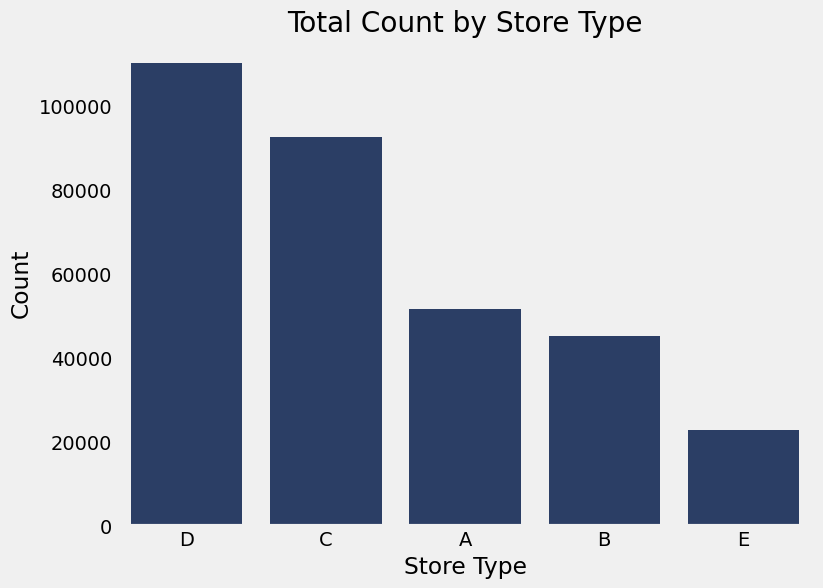

In [122]:
# Change the color palette to "cividis"
sns.set_palette("cividis")

# Calculate the total count and total sales per store type
store_type_counts = merged_df['store_type'].value_counts()
store_type_sales = merged_df.groupby('store_type')['sales'].sum()

# Create a bar plot with "cividis" color palette for total count
plt.figure(figsize=(8, 6))
sns.barplot(x=store_type_counts.index, y=store_type_counts.values)
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Total Count by Store Type')
plt.grid(False)
plt.show()


Examining the total sales count by store type offers valuable insights into the sales dynamics and customer demand within various store categories. Notably, Store Type D emerges as a standout performer with the highest sales count, indicating a robust customer base and widespread popularity for its offered products. Following closely is Store Type C, which, despite a somewhat lower sales count, still reflects a substantial customer base.

Conversely, Store Types A, B, and E exhibit comparatively lower sales counts, signaling potential areas for enhancement or the necessity to address competitive challenges. This analysis provides a comprehensive overview of the sales performance across different store types, highlighting areas of strength and opportunities for improvement.

## Total Amount in Sales by Store Type

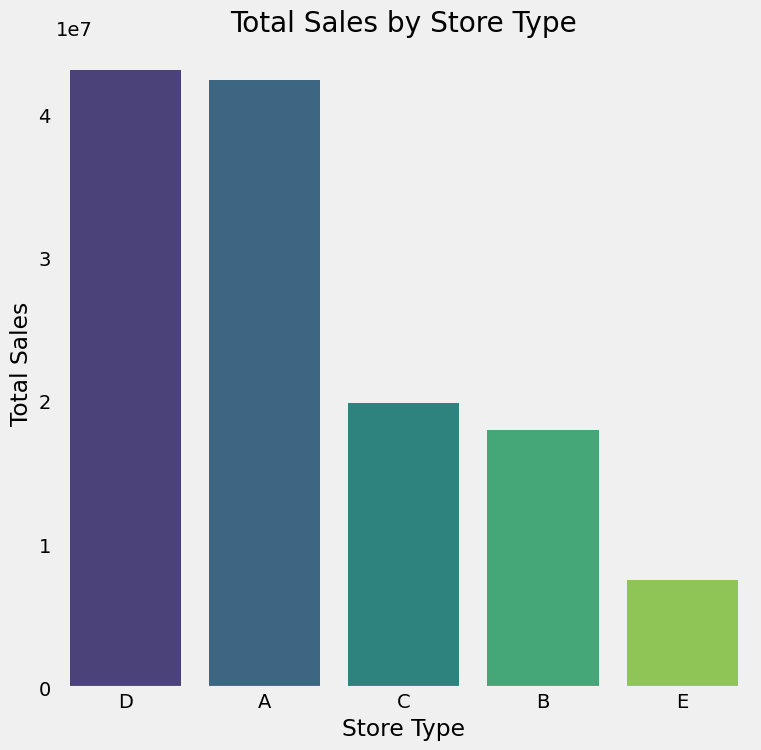

In [123]:
# Order the store types by total sales
store_type_sales = store_type_sales.sort_values(ascending=False)

# Create a bar plot with "viridis" color palette for total sales
plt.figure(figsize=(8, 8))
sns.barplot(x=store_type_sales.index, y=store_type_sales.values, order=store_type_sales.index, palette="viridis")
plt.xlabel('Store Type')
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Type')
plt.grid(False)
plt.show()

The total sales figures exhibit variations among various store types. Notably, Store Type D emerges as the leader with the highest total sales, underscoring its considerable contribution to the overall revenue. Following closely, Store Type A demonstrates substantial sales performance, securing a noteworthy position in the sales hierarchy. Store Type C occupies the third position in terms of total sales, while Store Types B and E record comparatively lower sales amounts.

Analyzing these sales variations across store types is crucial for pinpointing the primary drivers of revenue and emphasizing the significance of specific store types in influencing overall sales outcomes.

## **Average Sales by City**

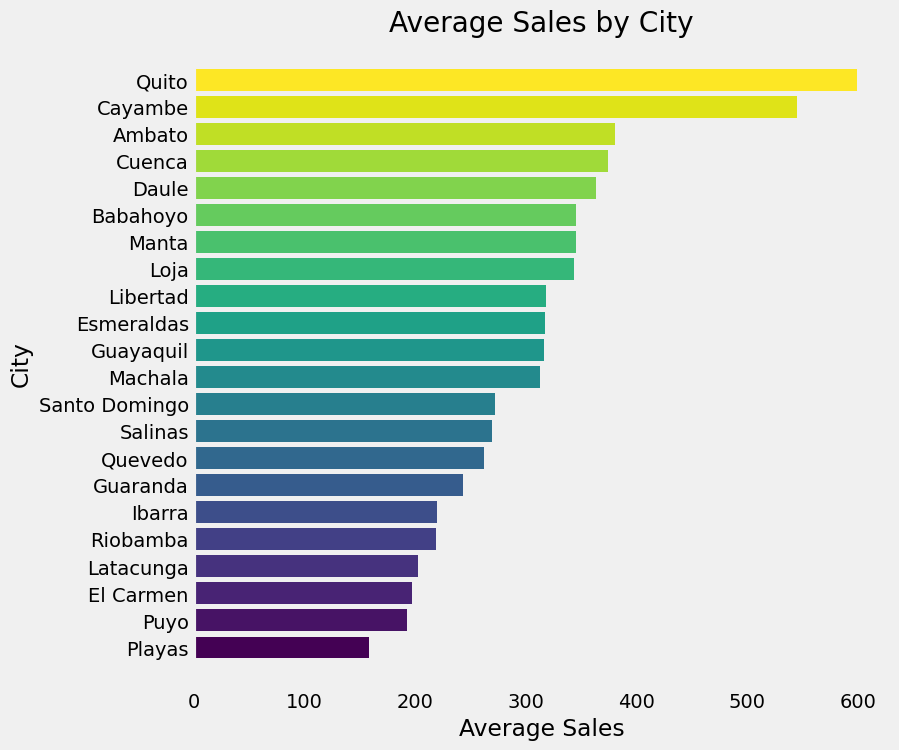

In [124]:
# Group by city and calculate the average sales
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Sort the data by average sales in ascending order
average_sales_by_city = average_sales_by_city.sort_values(ascending=True)

# Define colors for the bar plot using 'viridis' color palette
colors = cm.viridis(np.linspace(0, 1, len(average_sales_by_city)))

# Plot the average sales by city horizontally
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_city.index, average_sales_by_city.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('City')
plt.title('Average Sales by City')
plt.grid(False)
plt.show()

Quito leads in store count, markedly surpassing other cities. Cayambe follows as the second most populated city in terms of stores, trailed by Ambato, Daule, and Loja. Certain cities exhibit a moderate number of stores, while others have fewer establishments. Puyo, notably, has the lowest number of sales among the cities mentioned.

## **Average Sales by State**

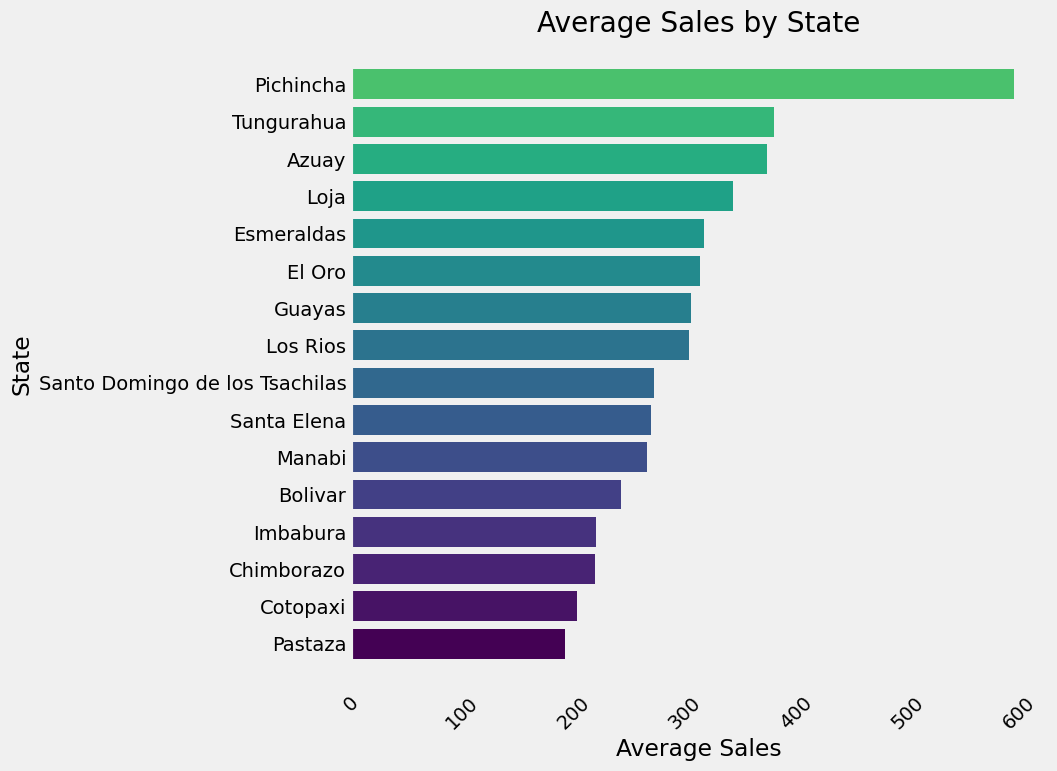

In [125]:
# Group by state and calculate the average sales
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Sort the data by average sales in descending order
average_sales_by_state = average_sales_by_state.sort_values(ascending=True)

# Plot the average sales by state
plt.figure(figsize=(8, 8))
plt.barh(average_sales_by_state.index, average_sales_by_state.values, color=colors)
plt.xlabel('Average Sales')
plt.ylabel('State')
plt.title('Average Sales by State')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

Pichincha stands out with the highest number of stores, largely attributed to the presence of Quito, the capital city. Guayas follows as the second most populous state in terms of stores, with Guayaquil serving as a significant city. Santo Domingo de los Tsachilas, Azuay, Manabi, Cotopaxi, Tungurahua, Los Rios, El Oro, Chimborazo, Imbabura, Bolivar, Pastaza, Santa Elena, and Loja each host a moderate number of stores.


## **Relationship between sales and transactions**

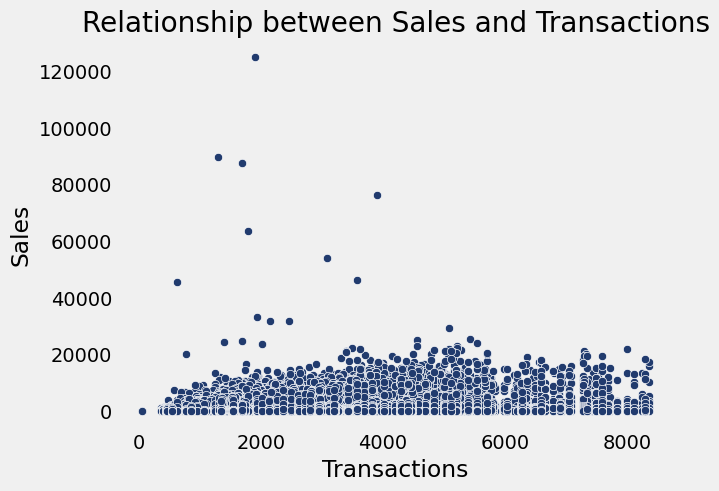

In [126]:
sns.scatterplot(x='transactions', y='sales', data=merged_df)
plt.xlabel('Transactions')
plt.ylabel('Sales')
plt.title('Relationship between Sales and Transactions')
plt.grid(False)
plt.show()

The scatter plot effectively illustrates the correlation between sales and transactions within the dataset, with each data point representing a specific instance characterized by corresponding sales and transaction values. Key insights derived from the scatter plot analysis include:

1. Clustered Data Points: The majority of data points converge in the lower sales region, forming a distinct concentration. This clustering suggests consistent transaction volumes associated with particular sales levels. Such concentration may signify a recurring sales pattern or trend that manifests at specific transaction levels.

2. Outliers: Notable outliers deviate from the primary cluster, occupying positions at higher sales levels for relatively lower transaction volumes, or vice versa. These outliers represent exceptional instances where sales significantly differ from the typical observations for a given number of transactions. Identification and comprehension of these outliers offer insights into unusual sales scenarios or exceptional business activities.

In summary, the scatter plot provides valuable insights into the intricate relationship between sales and transactions. The concentration of data points around specific sales and transaction levels implies the existence of recurrent patterns. Meanwhile, outliers spotlight exceptional cases that warrant deeper exploration to comprehend the factors influencing sales and transactions in unique instances. This analytical approach equips businesses with the knowledge needed to make informed decisions and formulate effective strategies for enhancing sales performance.

## Multivariate Analysis 

## **Correlation matrix of numerical variables**

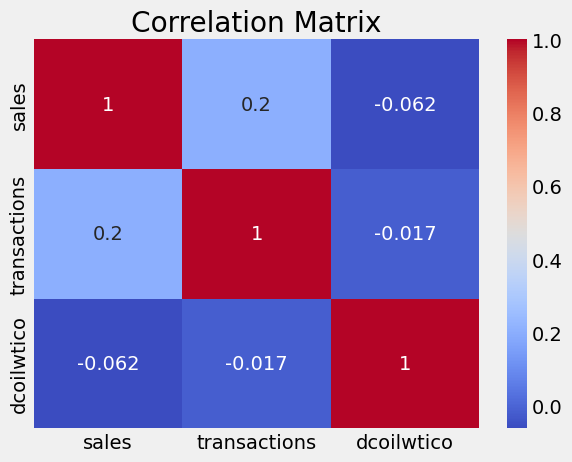

In [127]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Compute correlation matrix
corr_matrix = merged_df[numerical_vars].corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Correlation values span from -1 to 1, where -1 signifies a perfect negative correlation, 1 denotes a perfect positive correlation, and 0 indicates no correlation. The correlation matrix offers insights into the relationships between variables, shedding light on their interactions. Within this matrix, we observe correlations between different variables:

1. Sales and Transactions:

A weak positive correlation of around 0.200 exists between "Sales" and "Transactions." This implies a slight positive relationship, suggesting that as the number of transactions increases, there is a tendency for sales to also increase. However, the correlation is not robust.

2. Sales and Dcoilwito (Oil Prices):

A weak negative correlation of approximately -0.062 is observed between "Sales" and "Dcoilwito" (Oil Prices). This indicates a mild negative relationship, suggesting that as oil prices increase, there is a slight tendency for sales to decrease. However, the correlation is not statistically significant.

3. Transactions and Dcoilwito (Oil Prices):

A very weak negative correlation of about -0.017 exists between "Transactions" and "Dcoilwito" (Oil Prices). This suggests an almost negligible relationship, indicating that fluctuations in oil prices have minimal impact on the number of transactions.
In summary, the correlation values are relatively low, signaling that the relationships between these variables are not robust. It's important to note that other unconsidered factors may influence sales, transactions, and oil prices. Exploring additional variables is crucial for obtaining a more comprehensive understanding of their collective impact on sales and transactions.

## **Scatter Plot Marrix of numerical Variables**

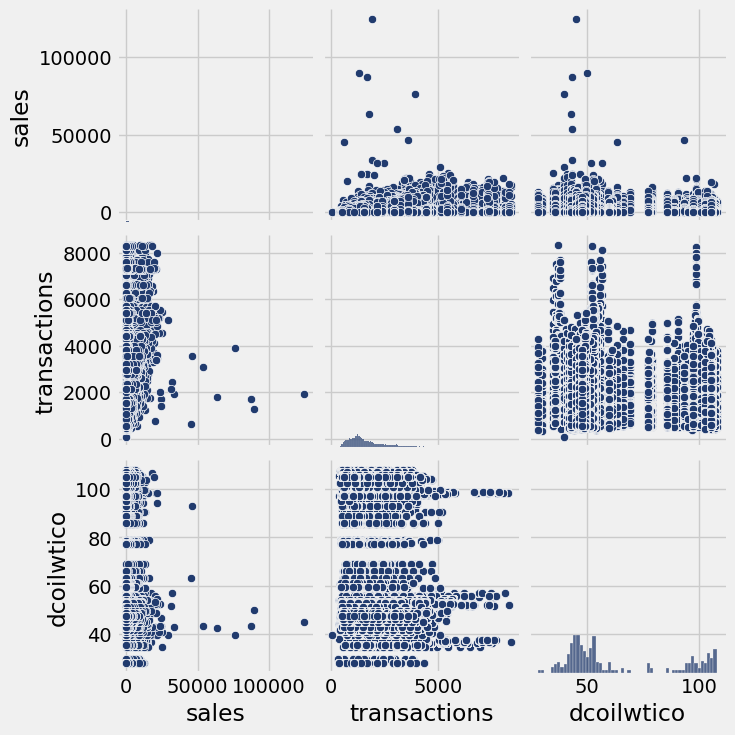

In [128]:
# Select numerical variables for correlation analysis
numerical_vars = ['sales', 'transactions', 'dcoilwtico']

# Plot scatter plot matrix
sns.pairplot(merged_df[numerical_vars])
plt.grid(False)

## **HYPOTHESIS TESTING**

### **Null Hypothesis (H0):** There is no significant difference in sales between promoted and non-promoted items.

### **Alternative Hypothesis (H1):** Items that are promoted have significantly higher sales compared to non-promoted items.

In [129]:
# Assuming you have a DataFrame named 'df' with 'sales' and 'onpromotion' columns
promoted_sales = merged_df[merged_df['onpromotion'] == 1]['sales']
non_promoted_sales = merged_df[merged_df['onpromotion'] == 0]['sales']

# Perform two-sample t-test
t_stat, p_value = ttest_ind(promoted_sales, non_promoted_sales, equal_var=False)

# Compare p-value with significance level
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a statistically significant difference in sales between promoted and non-promoted items.")
else:
    print("Fail to reject the null hypothesis. There is no statistically significant difference in sales between promoted and non-promoted items.")

Reject the null hypothesis. There is a statistically significant difference in sales between promoted and non-promoted items.


## **The Analytical Questions**

1. Is the train dataset complete (has all the required dates)?

In [132]:
min_date = train['date'].min()
max_date = train['date'].max()

# Generate a sequence of dates within the expected range
expected_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Find missing dates by comparing with the actual dates in the DataFrame
missing_dates = expected_dates[~expected_dates.isin(train['date'])]

if missing_dates.empty:
    print("The dataset is complete, and there are no missing dates.")
else:
    print("The dataset has missing dates:")
    print(missing_dates)

The dataset is complete, and there are no missing dates.


. Which dates have the lowest and highest sales for each year?

In [133]:
merged_df['year'] = merged_df['date'].dt.year  # Create a new column for the year

# Find dates with the lowest and highest sales for each year
min_sales_dates = merged_df.loc[merged_df.groupby('year')['sales'].idxmin()][['year', 'date', 'sales']]
max_sales_dates = merged_df.loc[merged_df.groupby('year')['sales'].idxmax()][['year', 'date', 'sales']]

# Display the results
print("Dates with the Lowest Sales for Each Year:")
print(min_sales_dates)

print("\nDates with the Highest Sales for Each Year:")
print(max_sales_dates)

Dates with the Lowest Sales for Each Year:
        year       date  sales
1       2013 2013-01-01    0.0
46278   2014 2014-01-01    0.0
119792  2015 2015-01-01    0.0
185692  2016 2016-02-08    0.0
284891  2017 2017-01-02    0.0

Dates with the Highest Sales for Each Year:
        year       date     sales
35583   2013 2013-11-12   46271.0
107400  2014 2014-12-08   45361.0
167529  2015 2015-11-11   33274.0
218238  2016 2016-05-02  124717.0
285029  2017 2017-01-02   23966.0


3. Did the earthquake impact sales?

A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

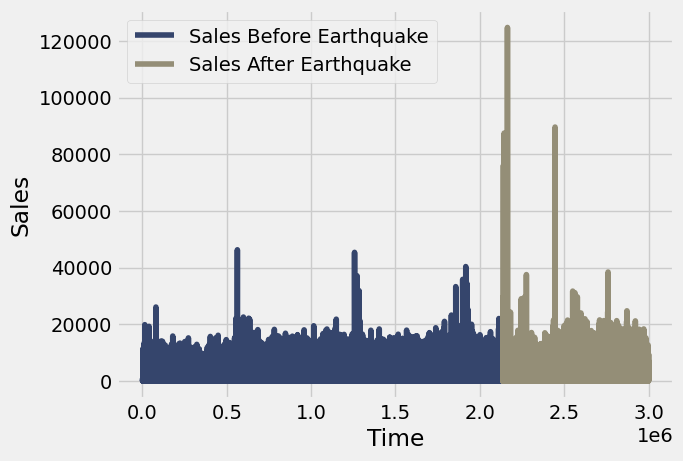

In [135]:
earthquake_date = pd.to_datetime('2016-04-16')

# Filter the sales data before and after the earthquake
sales_before_earthquake = train[train['date'] < earthquake_date]['sales']
sales_after_earthquake = train[train['date'] > earthquake_date]['sales']

# Set the colormap to cividis
colormap = cm.get_cmap('cividis')

# Choose different colors from the colormap
color_before_earthquake = colormap(0.2)
color_after_earthquake = colormap(0.6)  # Choosing a different color

# Plot the sales before and after the earthquake
plt.plot(sales_before_earthquake, color=color_before_earthquake, label='Sales Before Earthquake')
plt.plot(sales_after_earthquake, color=color_after_earthquake, label='Sales After Earthquake')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

4. Are certain groups of stores selling more products? (Cluster, city, state, type)?

## 1. Top 5 Clusters:

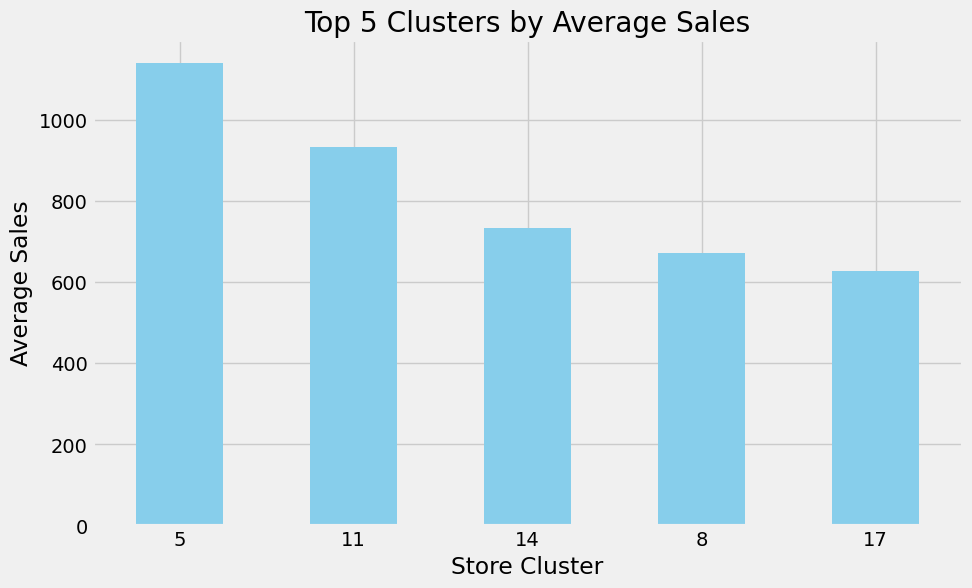

In [136]:
# Group by 'cluster' and calculate average sales for each group
average_sales_by_cluster = merged_df.groupby('cluster')['sales'].mean()

# Select the top 5 clusters
top5_clusters = average_sales_by_cluster.nlargest(5)

# Plotting the bar chart for top 5 clusters
plt.figure(figsize=(10, 6))
top5_clusters.plot(kind='bar', color='skyblue', rot=0)

# Adding labels and title
plt.xlabel('Store Cluster')
plt.ylabel('Average Sales')
plt.title('Top 5 Clusters by Average Sales')

# Display the plot
plt.show()

## 2. Top 5 Cities:

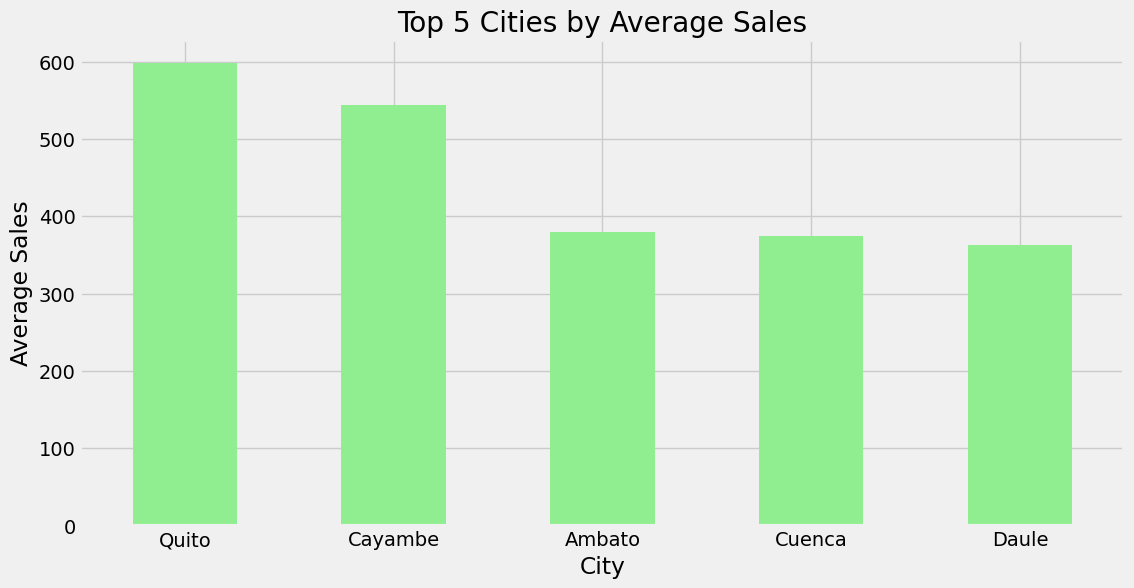

In [137]:
# Group by 'city' and calculate average sales for each group
average_sales_by_city = merged_df.groupby('city')['sales'].mean()

# Select the top 5 cities
top5_cities = average_sales_by_city.nlargest(5)

# Plotting the bar chart for top 5 cities
plt.figure(figsize=(12, 6))
top5_cities.plot(kind='bar', color='lightgreen', rot=0)

# Adding labels and title
plt.xlabel('City')
plt.ylabel('Average Sales')
plt.title('Top 5 Cities by Average Sales')

# Display the plot
plt.show()

## 3. Top 5 States

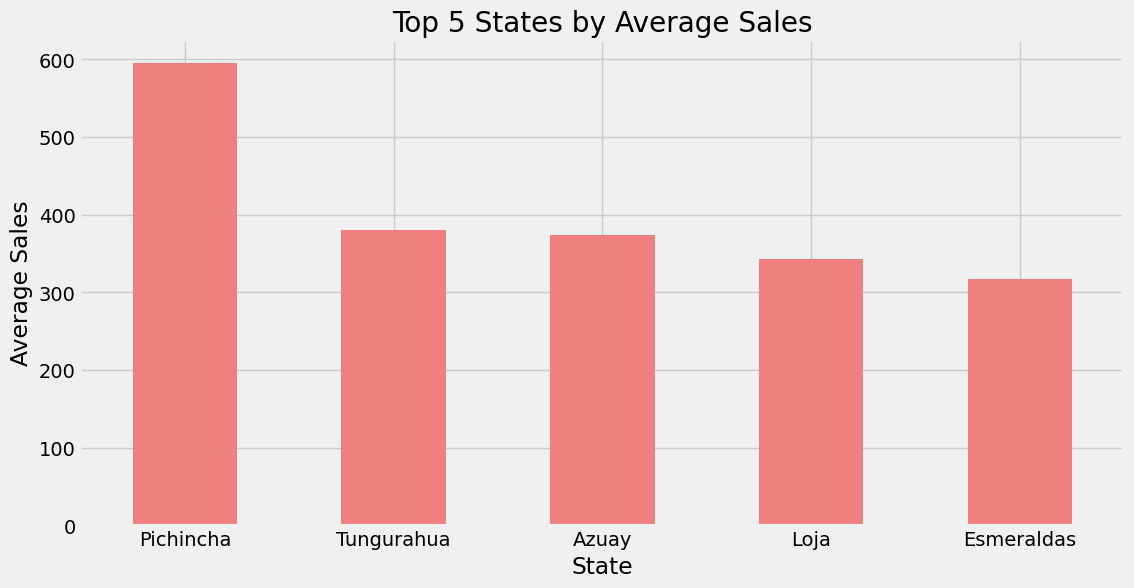

In [138]:
# Group by 'state' and calculate average sales for each group
average_sales_by_state = merged_df.groupby('state')['sales'].mean()

# Select the top 5 states
top5_states = average_sales_by_state.nlargest(5)

# Plotting the bar chart for top 5 states
plt.figure(figsize=(12, 6))
top5_states.plot(kind='bar', color='lightcoral', rot=0)

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Average Sales')
plt.title('Top 5 States by Average Sales')

# Display the plot
plt.show()

## 4. Top 5 Store Types:

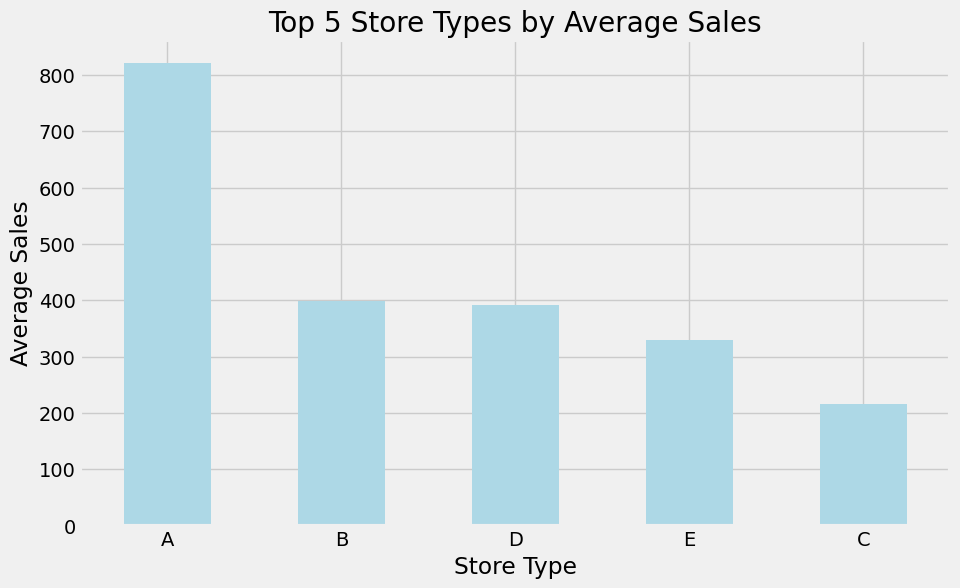

In [139]:
# Group by 'store_type' and calculate average sales for each group
average_sales_by_type = merged_df.groupby('store_type')['sales'].mean()

# Select the top 5 store types
top5_types = average_sales_by_type.nlargest(5)

# Plotting the bar chart for top 5 store types
plt.figure(figsize=(10, 6))
top5_types.plot(kind='bar', color='lightblue', rot=0)

# Adding labels and title
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.title('Top 5 Store Types by Average Sales')

# Display the plot
plt.show()

5. Are sales affected by promotions, oil prices and holidays?

Correlation between Sales and Promotions: 0.4180289197242377
Correlation between Sales and Oil Prices: -0.06150915261069533
Correlation between Sales and Holidays: -0.03706892930251698


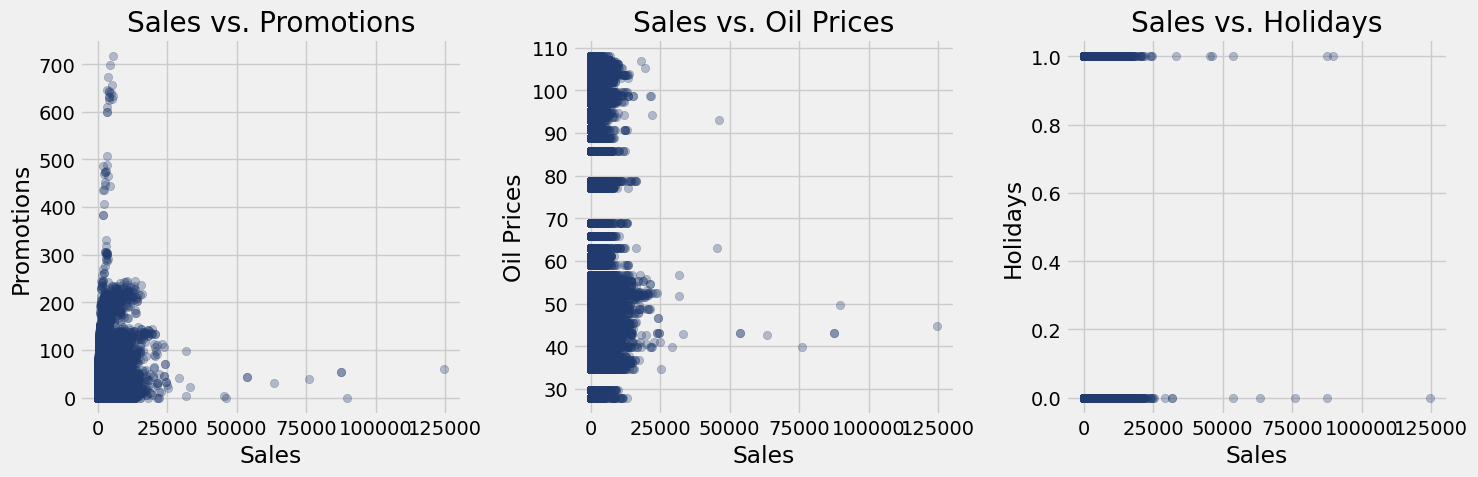

In [140]:
# Calculate correlations between sales and promotions, oil prices, holidays
corr_sales_promotions = merged_df['sales'].corr(merged_df['onpromotion'])
corr_sales_oil = merged_df['sales'].corr(merged_df['dcoilwtico'])

# One-hot encode 'holiday_type'
merged_df = pd.get_dummies(merged_df, columns=['holiday_type'], drop_first=True)

corr_sales_holidays = merged_df['sales'].corr(merged_df['holiday_type_Holiday'])

# Print the correlation values
print(f"Correlation between Sales and Promotions: {corr_sales_promotions}")
print(f"Correlation between Sales and Oil Prices: {corr_sales_oil}")
print(f"Correlation between Sales and Holidays: {corr_sales_holidays}")

# Visualize relationships using scatter plots
plt.figure(figsize=(15, 5))

# Scatter plot for Sales vs. Promotions
plt.subplot(1, 3, 1)
plt.scatter(merged_df['sales'], merged_df['onpromotion'], alpha=0.3)
plt.title('Sales vs. Promotions')
plt.xlabel('Sales')
plt.ylabel('Promotions')

# Scatter plot for Sales vs. Oil Prices
plt.subplot(1, 3, 2)
plt.scatter(merged_df['sales'], merged_df['dcoilwtico'], alpha=0.3)
plt.title('Sales vs. Oil Prices')
plt.xlabel('Sales')
plt.ylabel('Oil Prices')

# Scatter plot for Sales vs. Holidays
plt.subplot(1, 3, 3)
plt.scatter(merged_df['sales'], merged_df['holiday_type_Holiday'], alpha=0.3)
plt.title('Sales vs. Holidays')
plt.xlabel('Sales')
plt.ylabel('Holidays')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

1. Promotions:
The analysis reveals a positive correlation of approximately 0.42 between sales and promotions. This indicates a moderate positive impact of promotions on sales. During promotional periods, there is an increased likelihood of observing higher sales. This positive correlation suggests that customers tend to respond favorably to promotional offers, contributing to an uptick in sales.

2. Oil Prices:
A weak negative correlation of approximately -0.06 is observed between sales and oil prices. This suggests a slight negative relationship between sales and oil prices, although the correlation is close to zero. The findings imply that fluctuations in oil prices have minimal impact on sales. The weak negative correlation indicates that, on average, there is no strong evidence to suggest that changes in oil prices significantly influence customer purchasing behavior or overall sales.

3. Holidays:
A very weak negative correlation of approximately -0.04 is found between sales and holidays. This implies that there is almost no discernible relationship between sales and holidays. The data suggests that holidays, whether they are observed or not, do not appear to significantly impact sales. The negligible correlation underscores that holidays are unlikely to be a major factor influencing variations in sales.

In summary, promotions exhibit a relatively stronger influence on sales compared to oil prices and holidays. While promotions positively impact sales, the analysis suggests that oil prices and holidays show minimal or no discernible relationship with sales. This nuanced understanding can help businesses tailor their strategies, placing a greater emphasis on promotional efforts to drive sales.

6. What analysis can we get from the date and its extractable features?

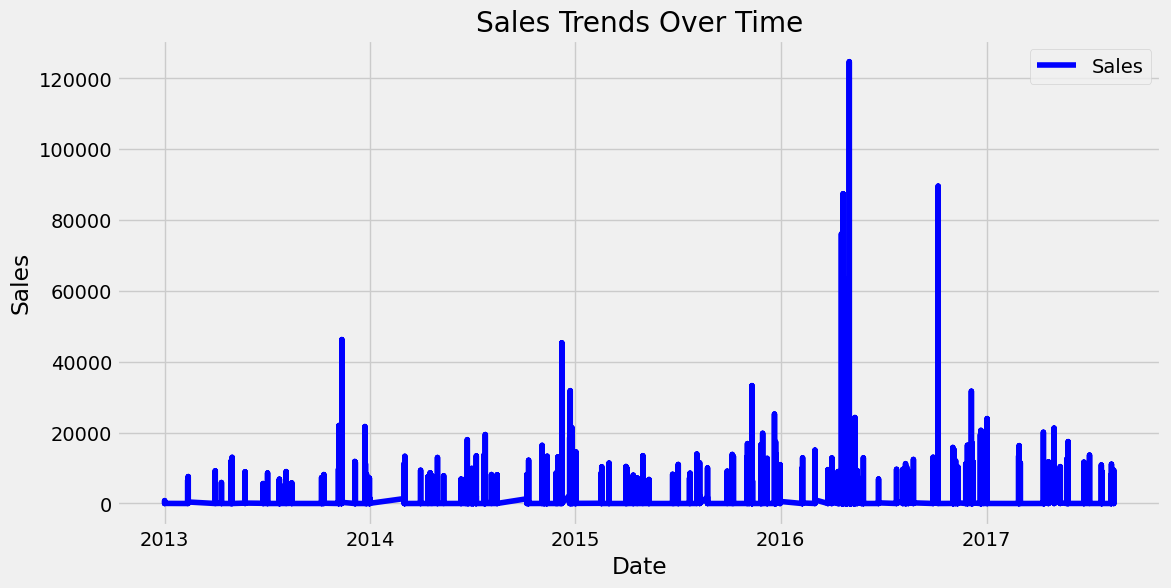

In [141]:
# Sales Trends Over Time
plt.figure(figsize=(12, 6))
plt.plot(merged_df['date'], merged_df['sales'], label='Sales', color='blue')
plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

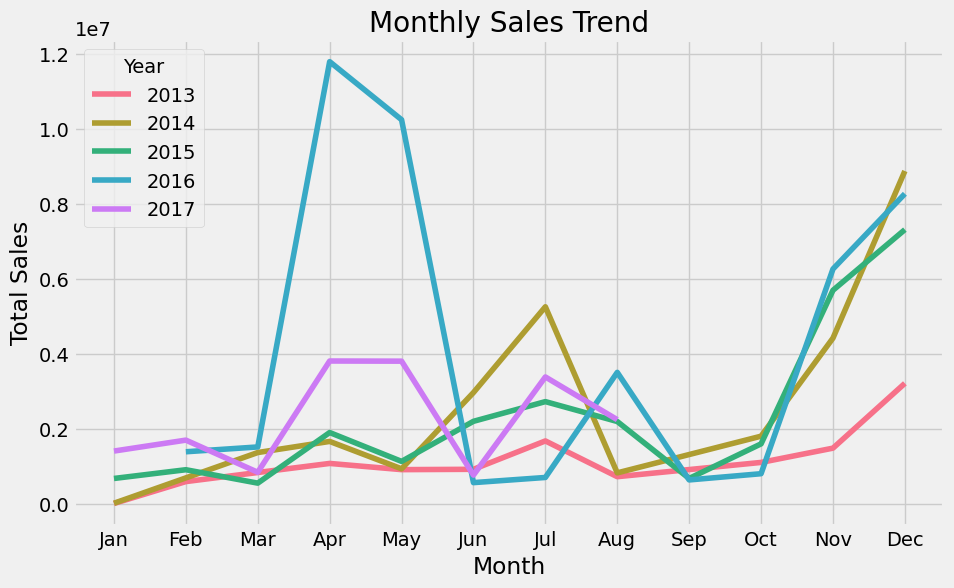

In [142]:
# Extracting Date Components
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])
merged_df_copy['year'] = merged_df_copy['date'].dt.year
merged_df_copy['month'] = merged_df_copy['date'].dt.month
merged_df_copy['day'] = merged_df_copy['date'].dt.day
merged_df_copy.head()


# Set distinct colors for each year
colors = sns.color_palette("husl", n_colors=len(merged_df_copy['year'].unique()))

# Visualize the Monthly Sales Trend
monthly_sales = merged_df_copy.groupby(['year', 'month'])['sales'].sum().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_sales, x='month', y='sales', hue='year', palette=colors)
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

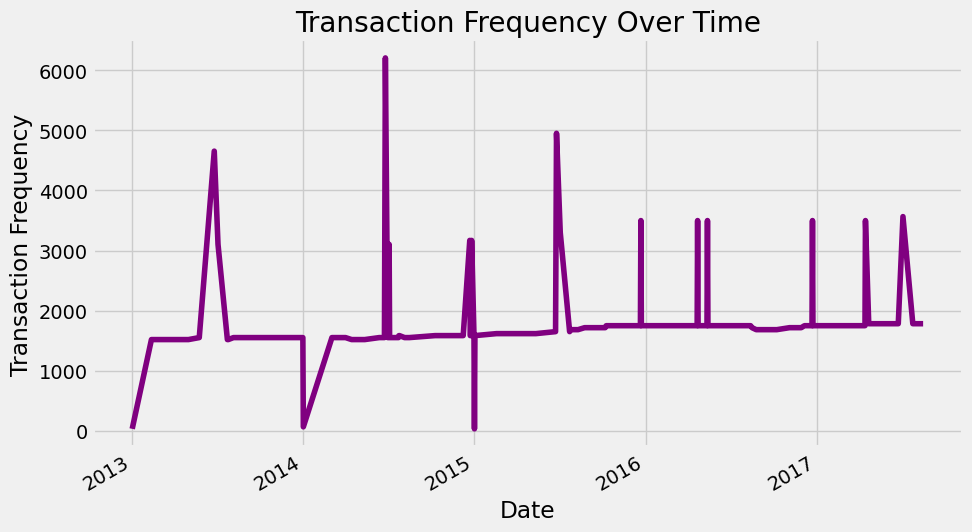

In [143]:
# Transaction Frequency
plt.figure(figsize=(10, 6))
merged_df['date'].value_counts().sort_index().plot(kind='line', color='purple')
plt.title('Transaction Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Transaction Frequency')
plt.show()


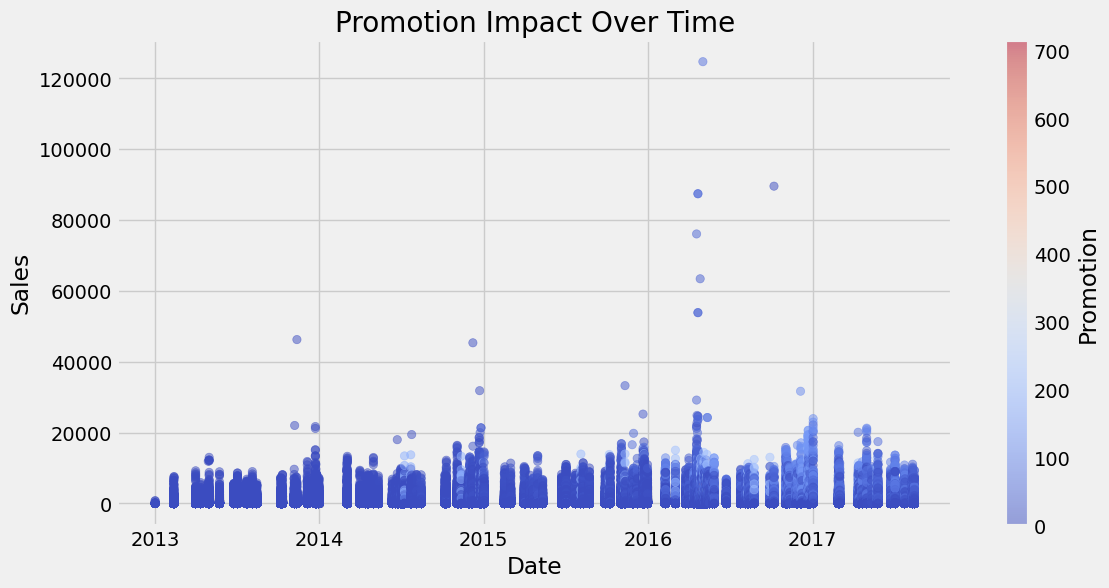

In [144]:
# Promotion Impact Over Time
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['date'], merged_df['sales'], c=merged_df['onpromotion'], cmap='coolwarm', alpha=0.5)
plt.title('Promotion Impact Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.colorbar(label='Promotion')
plt.show()


## Feature Enginering

## Train Dataset

Extracting Date Components (Day, Month, Year and Day of The Week).

In [146]:
# Extracting Date Components
merged_df_copy['date'] = pd.to_datetime(merged_df_copy['date'])
merged_df_copy['year'] = merged_df_copy['date'].dt.year
merged_df_copy['month'] = merged_df_copy['date'].dt.month
merged_df_copy['day'] = merged_df_copy['date'].dt.day
merged_df_copy.head()

,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,holiday_type,locale,locale_name,description,transferred,dcoilwtico,year,month,day
0,2013-01-01,25.0,LAWN AND GARDEN,2.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
1,2013-01-01,25.0,LADIESWEAR,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
2,2013-01-01,25.0,HOME CARE,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
3,2013-01-01,25.0,HOME APPLIANCES,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1
4,2013-01-01,25.0,HOME AND KITCHEN II,0.0,0.0,Salinas,Santa Elena,D,1,770,Holiday,National,Ecuador,Primer dia del ano,False,93.139999,2013,1,1


## Dropping Unneccessary Columns in The Merged and Test Datasets as it is not needed for our analysis

In [150]:
columns_to_drop = ['date', 'locale', 'locale_name', 'description', 'store_type', 'transferred', 'state']
merged_df_copy = merged_df_copy.drop(columns=columns_to_drop)

merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,25.0,LAWN AND GARDEN,2.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
1,25.0,LADIESWEAR,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
2,25.0,HOME CARE,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
3,25.0,HOME APPLIANCES,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
4,25.0,HOME AND KITCHEN II,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1


## Product Categorization Based on Families

In [151]:
unique_families = merged_df_copy['family'].unique()
unique_families

array(['LAWN AND GARDEN', 'LADIESWEAR', 'HOME CARE', 'HOME APPLIANCES',
       'HOME AND KITCHEN II', 'HOME AND KITCHEN I', 'HARDWARE',
       'GROCERY II', 'GROCERY I', 'FROZEN FOODS', 'EGGS', 'LINGERIE',
       'DELI', 'CLEANING', 'CELEBRATION', 'BREAD/BAKERY', 'BOOKS',
       'BEVERAGES', 'BEAUTY', 'BABY CARE', 'AUTOMOTIVE', 'DAIRY',
       'LIQUOR,WINE,BEER', 'MEATS', 'MAGAZINES', 'SEAFOOD',
       'SCHOOL AND OFFICE SUPPLIES', 'PRODUCE', 'PREPARED FOODS',
       'POULTRY', 'PLAYERS AND ELECTRONICS', 'PET SUPPLIES',
       'PERSONAL CARE'], dtype=object)

In [152]:
# Define the category lists for each product category
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI','PRODUCE', 'DAIRY','POULTRY','EGGS','SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES','SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE','PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS','HARDWARE']

# Categorize the 'family' column based on the product categories
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(food_families), 'FOODS', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(home_families), 'HOME', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(clothing_families), 'CLOTHING', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(grocery_families), 'GROCERY', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(stationery_families), 'STATIONERY', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(cleaning_families), 'CLEANING', merged_df_copy['family'])
merged_df_copy['family'] = np.where(merged_df_copy['family'].isin(hardware_families), 'HARDWARE', merged_df_copy['family'])

# Print the updated DataFrame
merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,25.0,LAWN AND GARDEN,2.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
1,25.0,LADIESWEAR,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
2,25.0,CLEANING,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
3,25.0,HOME,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1
4,25.0,HOME,0.0,0.0,Salinas,1,770,Holiday,93.139999,2013,1,1


## Feature Scaling

In [153]:
# Scaling Numeric Variables (Min-Max Scaling)
# create an instance of StandardScaler
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
merged_df_copy[num_cols] = scaler.fit_transform(merged_df_copy[num_cols])

# Display the updated dataframe
merged_df_copy.head()

,store_nbr,family,sales,onpromotion,city,cluster,transactions,holiday_type,dcoilwtico,year,month,day
0,25.0,LAWN AND GARDEN,-0.324316,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1
1,25.0,LADIESWEAR,-0.325920,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1
2,25.0,CLEANING,-0.325920,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1
3,25.0,HOME,-0.325920,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1
4,25.0,HOME,-0.325920,0.0,Salinas,1,-0.917916,Holiday,1.186995,2013,1,1


## Encoding The Categorical Variables

In [154]:
# Define the categorical columns to encode
categorical_columns = ["family", "city", "holiday_type"]

# Perform one-hot encoding
encoder = OneHotEncoder()
one_hot_encoded_data = encoder.fit_transform(merged_df_copy[categorical_columns])

# Create column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Convert the one-hot encoded data to a DataFrame
merged_df_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original dataframe with the one-hot encoded data
merged_df_encoded = pd.concat([merged_df_copy, merged_df_encoded], axis=1)

# Drop the original categorical columns
merged_df_encoded.drop(categorical_columns, axis=1, inplace=True)

# Print the head of the encoded DataFrame
merged_df_encoded.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,family_AUTOMOTIVE,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,25.0,-0.324316,0.0,1,-0.917916,1.186995,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25.0,-0.325920,0.0,1,-0.917916,1.186995,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25.0,-0.325920,0.0,1,-0.917916,1.186995,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,25.0,-0.325920,0.0,1,-0.917916,1.186995,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,25.0,-0.325920,0.0,1,-0.917916,1.186995,2013,1,1,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


## Test_df

In [158]:
# Extracting Date Components
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day
test.head()

,date,store_nbr,family,onpromotion,year,month,day
id,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
3000889,2017-08-16,1,BABY CARE,0,2017,8,16
3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3000891,2017-08-16,1,BEVERAGES,20,2017,8,16
3000892,2017-08-16,1,BOOKS,0,2017,8,16


In [160]:
# Dropping Unnecessary Columns
columns_to_drop = ['date']
test_df = test.drop(columns=columns_to_drop)
test_df.head()

,store_nbr,family,onpromotion,year,month,day
id,,,,,,
3000888,1,AUTOMOTIVE,0,2017,8,16
3000889,1,BABY CARE,0,2017,8,16
3000890,1,BEAUTY,2,2017,8,16
3000891,1,BEVERAGES,20,2017,8,16
3000892,1,BOOKS,0,2017,8,16


In [161]:
# Product Categorization Based on Families
food_families = ['BEVERAGES', 'BREAD/BAKERY', 'FROZEN FOODS', 'MEATS', 'PREPARED FOODS', 'DELI', 'PRODUCE', 'DAIRY', 'POULTRY', 'EGGS', 'SEAFOOD']
home_families = ['HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES']
clothing_families = ['LINGERIE', 'LADYSWARE']
grocery_families = ['GROCERY I', 'GROCERY II']
stationery_families = ['BOOKS', 'MAGAZINES', 'SCHOOL AND OFFICE SUPPLIES']
cleaning_families = ['HOME CARE', 'BABY CARE', 'PERSONAL CARE']
hardware_families = ['PLAYERS AND ELECTRONICS', 'HARDWARE']

test['family'] = np.where(test['family'].isin(food_families), 'FOODS', test['family'])
test['family'] = np.where(test['family'].isin(home_families), 'HOME', test['family'])
test['family'] = np.where(test['family'].isin(clothing_families), 'CLOTHING', test['family'])
test['family'] = np.where(test['family'].isin(grocery_families), 'GROCERY', test['family'])
test['family'] = np.where(test['family'].isin(stationery_families), 'STATIONERY', test['family'])
test['family'] = np.where(test['family'].isin(cleaning_families), 'CLEANING', test['family'])
test['family'] = np.where(test['family'].isin(hardware_families), 'HARDWARE', test['family'])

# Print the updated DataFrame
test.head()

,date,store_nbr,family,onpromotion,year,month,day
id,,,,,,,
3000888,2017-08-16,1,AUTOMOTIVE,0,2017,8,16
3000889,2017-08-16,1,CLEANING,0,2017,8,16
3000890,2017-08-16,1,BEAUTY,2,2017,8,16
3000891,2017-08-16,1,FOODS,20,2017,8,16
3000892,2017-08-16,1,STATIONERY,0,2017,8,16


In [164]:
# Encoding The Categorical Variables
# List of categorical columns to encode
categorical_columns = ["family"]

# Create an instance of the OneHotEncoder
encoder = OneHotEncoder()

# Perform one-hot encoding on the 'df_test' data for the specified categorical columns
one_hot_encoded_data = encoder.fit_transform(test[categorical_columns])

# Get the column names for the one-hot encoded data
column_names = encoder.get_feature_names_out(categorical_columns)

# Create a DataFrame with the one-hot encoded data and corresponding column names
test_encoded = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)

# Concatenate the original 'test_df' with the one-hot encoded data
test_encoded = pd.concat([test_df, test_encoded], axis=1)

# Drop the original categorical columns since they have been encoded
test_encoded.drop(categorical_columns, axis=1, inplace=True)

# Display the updated 'test_df_encoded' DataFrame
test_encoded.head()

,store_nbr,onpromotion,year,month,day,family_AUTOMOTIVE,family_BEAUTY,family_CELEBRATION,family_CLEANING,family_CLOTHING,family_FOODS,family_GROCERY,family_HARDWARE,family_HOME,family_LADIESWEAR,family_LAWN AND GARDEN,"family_LIQUOR,WINE,BEER",family_PET SUPPLIES,family_STATIONERY
3000888,1.0,0.0,2017.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000889,1.0,0.0,2017.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000890,1.0,2.0,2017.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000891,1.0,20.0,2017.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000892,1.0,0.0,2017.0,8.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

## Data Splitting

In [165]:
train_set = merged_df_encoded.loc[merged_df_encoded['year'].isin([2013, 2014, 2015, 2016])]
eval_set = merged_df_encoded.loc[merged_df_encoded['year'] == 2017]

In [166]:
train_set.shape

(284889, 50)

In [167]:
eval_set.head()

,store_nbr,sales,onpromotion,cluster,transactions,dcoilwtico,year,month,day,family_AUTOMOTIVE,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
284889,41.0,-0.315494,0.0,4,-0.299065,-0.453674,2017,1,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284890,42.0,-0.321910,0.0,2,-0.220042,-0.453674,2017,1,2,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284891,42.0,-0.325920,0.0,2,-0.220042,-0.453674,2017,1,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284892,42.0,-0.315494,1.0,2,-0.220042,-0.453674,2017,1,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
284893,42.0,1.258034,21.0,2,-0.220042,-0.453674,2017,1,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [168]:
eval_set.shape

(37158, 50)

In [169]:
# Separate the target variable and features for training and testing
X_train = train_set.drop('sales', axis=1)
y_train = train_set['sales'] 


X_eval = eval_set.drop('sales', axis=1)  
y_eval = eval_set['sales']

In [170]:
# Initialize the results dataframe
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

## Model 1. Linear Regression

In [171]:
# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_eval)

# Calculate metrics
lr_mse = mean_squared_error(y_eval, lr_predictions)
lr_mae = mean_absolute_error(y_eval, lr_predictions)

# Apply the absolute value function to both y_eval and lr_predictions
y_eval_abs = abs(y_eval)
lr_predictions_abs = abs(lr_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
lr_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, lr_predictions_abs))

# Create a DataFrame to store results for Linear Regression
results_lr = pd.DataFrame({'Model': ['Linear Regression'],
                            'RMSLE': [lr_rmsle],
                            'RMSE': [np.sqrt(lr_mse)],
                            'MSE': [lr_mse],
                            'MAE': [lr_mae]}).round(2)

# Print the results_lr dataframe
results_lr

,Model,RMSLE,RMSE,MSE,MAE
0,Linear Regression,0.27,0.84,0.71,0.37


## Model 2. Random Forest Regression

In [172]:
# Random Forest Regression Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_eval)

# Calculate metrics
rf_mse = mean_squared_error(y_eval, rf_predictions)
rf_mae = mean_absolute_error(y_eval, rf_predictions)

# Apply the absolute value function to both y_eval and rf_predictions
y_eval_abs = abs(y_eval)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
results_rf

,Model,RMSLE,RMSE,MSE,MAE
0,Random Forest,0.23,0.72,0.51,0.25


## Model 3. Gradient Boosting Regression

In [173]:
# Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)
gb_predictions = gb_model.predict(X_eval)

# Calculate metrics
gb_mse = mean_squared_error(y_eval, gb_predictions)
gb_mae = mean_absolute_error(y_eval, gb_predictions)

# Apply the absolute value function to both y_eval and gb_predictions
y_eval_abs = abs(y_eval)
gb_predictions_abs = abs(gb_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
gb_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, gb_predictions_abs))

# Create a DataFrame to store results for Gradient Boosting
results_gb = pd.DataFrame({'Model': ['Gradient Boosting'],
                            'RMSLE': [gb_rmsle],
                            'RMSE': [np.sqrt(gb_mse)],
                            'MSE': [gb_mse],
                            'MAE': [gb_mae]}).round(2)

# Print the results_gb dataframe
results_gb

,Model,RMSLE,RMSE,MSE,MAE
0,Gradient Boosting,0.24,0.67,0.45,0.29


## Model 4. ARIMA

In [174]:
# ARIMA Model
# d and q are equal to zero as data is already stationary
p = 1
d = 0 
q = 0  

# Create an instance of the ARIMA model
arima_model = ARIMA(y_train, order=(p, d, q))

# Fit the model to the training data
arima_model_fit = arima_model.fit()

# Make predictions on the evaluation data
arima_predictions = arima_model_fit.predict(start=len(y_train), end=len(y_train) + len(X_eval) - 1)

# Calculate evaluation metrics
arima_mse = mean_squared_error(y_eval, arima_predictions)
arima_rmse = np.sqrt(arima_mse)

# Apply the absolute value function to y_eval to remove negative signs
y_eval_abs = abs(y_eval)
arima_predictions_abs = abs(arima_predictions)

# Calculate the Mean Absolute Error (MAE)
arima_mae = mean_absolute_error(y_eval, arima_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
arima_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, arima_predictions_abs))

# Create a DataFrame to store results for ARIMA
results_arima = pd.DataFrame({'Model': ['ARIMA'],
                            'RMSLE': [arima_rmsle],
                            'RMSE': [np.sqrt(arima_mse)],
                            'MSE': [arima_mse],
                            'MAE': [arima_mae]}).round(2)

# Print the results_arima dataframe
results_arima

,Model,RMSLE,RMSE,MSE,MAE
0,ARIMA,0.45,1.09,1.19,0.5


## Model 5. SARIMA

In [175]:
# Set the order and seasonal order parameters
# Seasonal autoregressive order
P = 0  
# Seasonal differencing order
D = 0  
# Seasonal moving average order
Q = 0  
# Number of time steps in each season (chosen based on the number of months each year)
s = 12  

# Create an instance of the SARIMA model
sarima_model = SARIMAX(endog=y_train, exog=X_train, order=(p, d, q), seasonal_order=(P, D, Q, s))

# Fit the model to the training data
sarima_fit = sarima_model.fit()

# Make predictions on the evaluation data
sarima_predictions = sarima_fit.forecast(steps=len(y_eval), exog=X_eval)

# Calculate metrics
sarima_mse = mean_squared_error(y_eval, sarima_predictions)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(y_eval, sarima_predictions)
sarima_rmsle = np.sqrt(mean_squared_error(np.log1p(y_eval), np.log1p(sarima_predictions)))

# Create a DataFrame to store results for SARIMA
results_sarima = pd.DataFrame({'Model': ['SARIMA'],
                                'RMSLE': [sarima_rmsle],
                                'RMSE': [sarima_rmse],
                                'MSE': [sarima_mse],
                                'MAE': [sarima_mae]}).round(2)

# Print the results_sarima dataframe
results_sarima

,Model,RMSLE,RMSE,MSE,MAE
0,SARIMA,0.39,0.84,0.71,0.37


In [176]:
# Reinitialize an empty DataFrame with the specified columns
results_df = pd.DataFrame(columns=['Model', 'RMSLE', 'RMSE', 'MSE', 'MAE'])

# Append results to the DataFrame
results_df = pd.concat([results_df, results_lr], ignore_index=True)
results_df = pd.concat([results_df, results_rf], ignore_index=True)
results_df = pd.concat([results_df, results_gb], ignore_index=True)
results_df = pd.concat([results_df, results_arima], ignore_index=True)
results_df = pd.concat([results_df, results_sarima], ignore_index=True)

# Sort the DataFrame based on RMSLE in ascending order
results_df = results_df.sort_values(by='RMSLE', ascending=True)

# Reset the index of the DataFrame
results_df = results_df.reset_index(drop=True)

# Print the Final Results DataFrame
print(results_df)

               Model  RMSLE  RMSE   MSE   MAE
0      Random Forest   0.23  0.72  0.51  0.25
1  Gradient Boosting   0.24  0.67  0.45  0.29
2  Linear Regression   0.27  0.84  0.71  0.37
3             SARIMA   0.39  0.84  0.71  0.37
4              ARIMA   0.45  1.09  1.19  0.50


1. The RMSLE serves as a metric suited for target variables with a broad range of values, and a diminished RMSLE reflects a more fitting model. 
2.  RMSE quantifies the average magnitude of errors between predicted and actual values, with a lower RMSE signifying superior model performance. 
3. MSE, the mean of squared errors, offers an assessment of overall model accuracy, where lower MSE values indicate enhanced performance. The MAE gauges average error magnitude irrespective of direction, with lower MAE values denoting heightened model accuracy.

Both RMSLE and RMSE serve as indicators of the model's prediction error, with diminished values indicating superior performance. MSE provides an evaluation of squared errors between predicted and actual values, 
4. while MAE measures the average absolute difference between predictions and actuals.

In summary, these metrics delineate each model's performance, with lower RMSLE, RMSE, MSE, and MAE values pointing to enhanced efficacy. Notably, the Random Forest and Gradient Boosting models exhibit superior performance compared to Linear Regression, ARIMA, and SARIMA models based on these metrics.